In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
#read in data file and skip to data
file=open("/Users/Roslyn/Desktop/run-XXXII", "r")

In [3]:
with file as f:
    lines_after_6 = f.readlines()[7:]

In [4]:
#extract first two coloumns and convert to float
col1=[]
for x in lines_after_6:
    col1.append(float(x.split()[0]))
        
col2=[]
for x in lines_after_6:
    col2.append(float(x.split()[1]))
    
#combine real and imaginary parts to give list of complex data outputs
data=np.vectorize(complex)(col1, col2)

In [5]:
#enter constants
f_mode1 = 4.993017E6
f_mode2 = 5.505658500E+6 #- 2.8
kappa_1 = 0.000576417
kappa_2 = 0.000619449
Q1 = 4.4E7
Q2 = 4.84E7
dt=0.01
fs=100

w_mode1= 2*np.pi*f_mode1
w_mode2= 2*np.pi*f_mode2
tau1=Q1/w_mode1
tau2=Q2/w_mode2

h0=0.0005
trap=0.848

Zsquid= 1.2e6

In [6]:
data1=data[:10000000]

In [7]:
print(len(data))

24089000


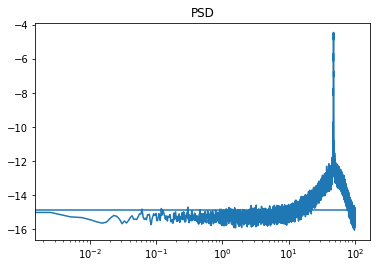

In [8]:
#PSD using Welch method 
f_1, S_1 = welch(
        (data1)-np.mean(data1), fs=fs, nperseg=(len(data1)/256),
         return_onesided=False, detrend=None, scaling='density', window='hanning')

#to plot log log have shifted frequency axis to positive 
plt.plot(f_1+abs(np.min(f_1)), 10*np.log10(S_1))
plt.title('PSD')
plt.xscale('log')


In [9]:
#SPECTRAL DISPLACEMENT DENSITY Su
#eq (8) GW Summary

#omega frequency axis, add mode freq 1 and convert from Hz to rad/s, and create squared axis 
w_1= [(x+f_mode1)*(2*np.pi) for x in f_1]
w_1sq= [x**2 for x in w_1]

#multiply 1/omega^2 list and Sv 
product1= [(1/a) * b for a, b in zip(w_1sq, S_1)]
 
#put into equation for Su(omega)
#10^-6 squared is a conversion from micro V to V
constants1 = (1/kappa_1**2)*(1/(Zsquid**2)*(10**(-6))**2)
Su1 = [x*(constants1) for x in product1]

Text(0.5, 1.0, 'Spectral Displacement Density')

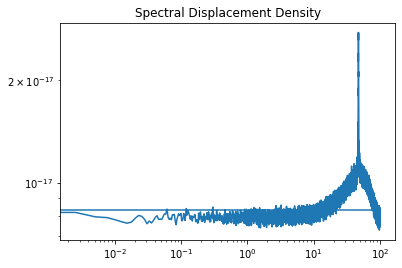

In [10]:
plt.plot(f_1+abs(np.min(f_1)), np.sqrt(Su1))
plt.xscale('log')
plt.yscale('log')
plt.title('Spectral Displacement Density')

In [11]:
#transfer function (equation 6 GW Summary)
def trans1(w):
    return np.absolute(((-w)**2*h0*trap/2)/((w*1j)**2+(w*1j)/tau1+w_mode1**2))

In [12]:
H_1=np.array(list(map(trans1,2*np.pi*(f_1+f_mode1))))

Text(0.5, 1.0, 'Transfer Function')

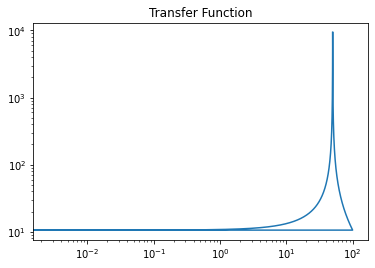

In [13]:
plt.plot(f_1+abs(np.min(f_1)), H_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Transfer Function')

Text(0.5, 1.0, 'Strain Sensitivity ')

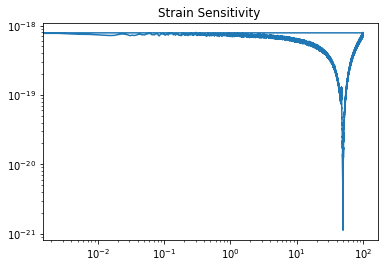

In [14]:
h_1=np.sqrt(Su1)/H_1

plt.plot(f_1+abs(np.min(f_1)), h_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Strain Sensitivity ')

In [15]:
#convert Su back to complex time series 
Su1i=np.fft.ifft(Su1)
print(Su1i[:10])

[8.95364012e-35+4.46983356e-53j 1.63392184e-35-7.09015509e-37j
 5.07443958e-36-1.42274837e-36j 4.12812512e-36-2.09912645e-36j
 3.67395056e-36-2.62394962e-36j 3.25380921e-36-3.09250729e-36j
 2.65292910e-36-3.42985139e-36j 1.98595599e-36-3.75883535e-36j
 1.33177951e-36-3.95514614e-36j 7.38250473e-37-4.03780053e-36j]


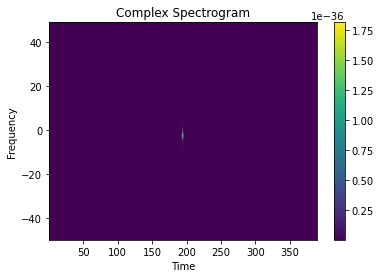

In [16]:
#complex data spectrogram
f, t, Sxx = signal.spectrogram(Su1i-np.mean(Su1i), 100, nperseg=100, return_onesided=False, mode='complex')
plt.pcolormesh(t, fftshift(f), fftshift(abs(Sxx)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Complex Spectrogram')
plt.show()

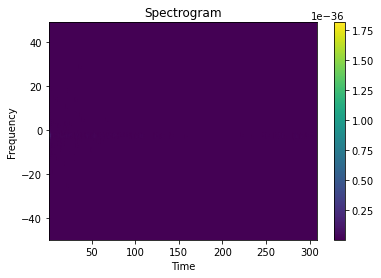

In [17]:
#extract section without power spike 
SxxA=np.array(Sxx)
SxxC= SxxA[0:100,0:350]

difft=np.delete(t[:351],0)

plt.pcolormesh(difft, fftshift(f), fftshift(abs(SxxC), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Spectrogram')
plt.show()

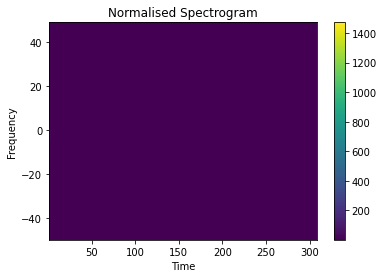

In [18]:
#FIND THRESHOLD NOISE AMPLITUDE AT FREQUENCY AWAY FROM RESONANT MODE 

#normalise data spectrogram 
absnormSxx=[]

for i in range(0,len(SxxC)):
    absnormSxx.append(abs((SxxC[i]/np.median(abs(SxxC[i])))))
    
plt.pcolormesh(difft, fftshift(f), fftshift(absnormSxx, axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Normalised Spectrogram')
plt.show()

In [19]:
#differencing for data spectrogram (D for data)

timecolsD=np.transpose(absnormSxx)

absdiffD=[]
slice1=[]

for j in range(0,len(absnormSxx)):
    slice1.clear()
    for i in range(0,(len(absnormSxx[0])-1)):
        slice1.append(abs(timecolsD[i+1][j]-timecolsD[i][j]))
    absdiffD.append(slice1[:])
    
#print(len(absdiffD))
#print(len(absdiffD[0]))

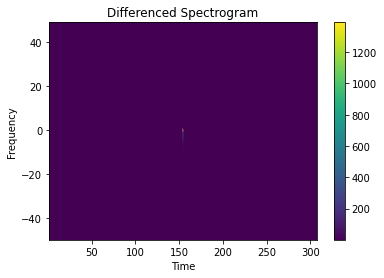

In [20]:
difftD=np.delete(t[:350],0)

plt.pcolormesh(difftD, fftshift(f), np.array(fftshift(absdiffD)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Differenced Spectrogram')
plt.show()

In [21]:
#select area away from res mode and find max amplitude (around 25-40Hz)

#this corresponds to frequency index approx 26-41
#print(np.shape(absdiffD))
#print(f)
absdiffDA=np.array(absdiffD)

noiserows=absdiffDA[26:41,:].copy()
print(np.shape(noiserows))

threshold=np.amax(noiserows)
print(threshold)

(15, 349)
6.5680502833261


In [22]:
#create loop which essentially completes transient difference stest for 100 delta functions 
#at each of a range of h amplitudes to count if they are above threshold 

In [23]:
#(range and arange don't work well with non integer values)
h=np.linspace(1e-22,1e-21,10)
#print(len(h))
#print(h)

In [24]:
#create simulated transient for each h amplitude and resample to match dimension of spec to add
Su_sim=[]
slice2=[]

for i in range(0,len(h)):
    slice2.clear()
    for j in range(0,len(H_1)):
        slice2.append((h[i]*abs(H_1[j]))**2)
    Su_sim.append(signal.resample(slice2[:],len(f)))
    #Su_sim.append(slice2[:])
        
print(np.shape(Su_sim))
#print(len(Su_sim))
#print(len(Su_sim[0]))
#print(Su_sim)

(10, 100)


In [25]:
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[0])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[1])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[2])
#plt.plot(f_1+abs(np.min(f_1)), Su_sim[3])
#plt.xscale('log')
#plt.yscale('log')
#plt.title('Transient Sim Spectral Displacement Density')

#transient shape before resampling looks to be correct 

In [26]:
import random

In [27]:
count=0
allcounts=[]

for y in range(0,len(h)):
    for x in range(0,100):
        randomcol=random.randint(0,(len(SxxC[0])-1))
        #print(randomcol)
        SxxC[:,randomcol]= [a+b for a,b in zip(SxxC[:,randomcol],Su_sim[y])]
    
        absnormSxxsim=[]

        for k in range(0,len(SxxC)):
            absnormSxxsim.append(abs((SxxC[k]/np.median(abs(SxxC[k])))))
    
        #print(absnormSxxsim[0][0])
    
        timecols=np.transpose(absnormSxxsim)
        absdiff=[]
        slice3=[]

        for j in range(0,len(absnormSxxsim)):
            slice3.clear()
            for i in range(0,(len(absnormSxxsim[0])-1)):
                slice3.append(abs(timecols[i+1][j]-timecols[i][j]))
            absdiff.append(slice3[:])
    
        #print(absdiff[0][0])
    
        maxamp=np.amax(absdiff)
        print(maxamp)
    
        if maxamp > threshold:
            count+=1
    
        SxxC[:,randomcol]= [a-b for a,b in zip(SxxC[:,randomcol],Su_sim[y])]

    allcounts.append(count)
    count=0


#print(count)
print(allcounts)
    

    
   

1390.536419173351
1382.4554394794905
1380.4770305422157
1380.4770305422157
1390.5364191733447
1380.4770305422157
1390.5364191733447
1380.4770305422157
1390.5364191733447
1380.4770305422157
1380.4770305422157
1390.5364191733447
1380.4770305422157
1390.5364191733447
1380.4770305422207
1380.4770305422207
1380.4770305422207
1390.5364191733447
1265.7593371287956
1380.4770305422207
1380.4770305422207
1390.5364191733447
1390.5364191733447
1390.5364191733447
1380.4770305422207
1380.4770305422207
1380.4770305422207
1390.5364191733447
1380.4770305422207
1380.4770305422207
1380.4770305422207
1380.4770305422207
1390.5364191733447
1390.5364191733447
1390.5364191733447
1380.4770305422207
1380.4770305422207
1380.4770305422207
1380.4770305422207
1390.5364191733447
1390.5364191733447
1390.5364191733447
1390.5364191733447
1390.5364191733447
1380.4770305422207
1390.5364191733447
1390.5364191733447
1390.5364191733447
1380.4770305422207
1380.4770305422207
1390.5364191733447
1390.5364191733447
1380.47703054

4586.82474583565
4591.109713902947
4556.798739372082
4555.975906783133
4588.386645658459
4557.144297739006
4590.822237052288
4556.228176379531
4555.327374947914
4556.55641821216
4556.206853843049
4556.054597440654
4556.107191047456
4587.358507166754
4555.567325830195
4590.142169478487
4555.013507233607
4590.227877929835
4555.789502333857
4555.787697340574
4556.018928585099
4589.754401446309
4556.050090518292
4556.193843619293
4587.4345217779655
4556.1709206549995
4555.503296563579
4556.160191893804
4556.3017221684195
4588.441829370066
4591.618243129217
4587.0203190675675
4589.758184925638
4555.529868138627
4553.895795165164
4589.232469722336
4555.886709801829
4556.900027249296
4588.453355762458
4587.529438983128
4556.316359313002
4590.291925778392
4587.816173932612
4555.7321498234705
4555.423740540611
4555.929037571744
4555.338553642199
4556.6966502127425
4556.096579385106
4590.877554450923
4587.247539572119
4555.338553642199
4591.027532154831
4587.616153529234
4587.689993553577
4589.7

14870.529844225039
14762.892184503207
14763.1330492723
14763.145076499584
14871.395749755226
14762.14164740335
14761.7792543967
14871.682815292708
14870.429506241884
14762.028714539878
14763.216452479994
18356.763546868235
18358.95483073045
16817.06900903627
18225.34440735358
18225.74028362212
18356.002561369944
18357.16607496333
18225.451142629092
18359.28759673772
18226.04651554184
18358.41049733372
18225.57939196029
18358.129864203696
18357.364027528314
18360.28765149285
18226.315260091786
18225.255150430537
18344.89532931773
18224.4905285679
18357.364027528314
18224.44142904325
18225.682455203638
18357.194466213645
18225.809737923144
18358.119377967054
18225.301515313142
18226.614327518575
18225.739041898098
18356.00625311099
18356.093432176247
18224.911469605813
18358.129864203696
18357.364027528314
18225.382286568274
18226.469395370055
18356.345488894884
18225.71631988869
18224.94105560458
18356.066659435703
18359.28759673772
18359.577708216064
18225.609538076224
18225.3514596475

Text(0, 0.5, 'Fraction of Events above threshold')

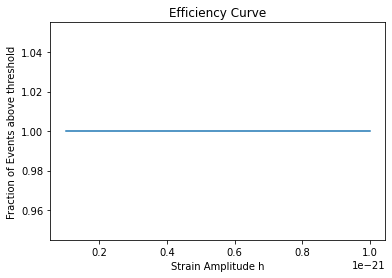

In [28]:
fraccounts=[x/100 for x in allcounts]

plt.plot(h,fraccounts)
plt.title('Efficiency Curve')
plt.xlabel('Strain Amplitude h')
plt.ylabel('Fraction of Events above threshold')
#plt.ylim(0,1)

In [29]:
#plt.pcolormesh(difft, fftshift(f), fftshift(abs(SxxC), axes=0), shading='gouraud')
#plt.colorbar()
#plt.xlim(0,350)
#plt.ylabel('Frequency')
#plt.xlabel('Time')
#plt.title('Sim Spectrogram')
#plt.show()

#looks like transient isnt being added

In [30]:
#plt.pcolormesh(difft, fftshift(f), fftshift((absnormSxxsim), axes=0), shading='gouraud')
#plt.colorbar()
#plt.xlim(0,350)
#plt.ylabel('Frequency')
#plt.xlabel('Time')
#plt.title('Norm Spectrogram')
#plt.show()